# Tensorflowを用いた強化学習の実装

機械学習用ライブラリTensorflowを用いて、Pythonで強化学習を実装します。<br>
今回のハンズオンでは、五目並べんお実装とモンテカルロ法によって自己対戦で強化学習をさせます。

In [15]:
import tensorflow as tf
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from PIL import Image, ImageDraw
import copy

In [22]:
!pip  --version

/bin/sh: tensorflow: command not found


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


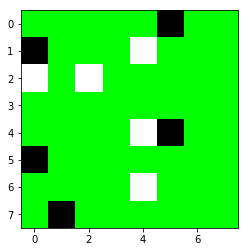

In [16]:
size = 8

# 五目並べのプログラム
class Game:
    # コンストラクタ
    def __init__(self):
        self.size = size
        self.square = [[0 for _ in range(self.size)] for _ in range(self.size)]
        self.turn = 1
    # 石を置く
    def put(self, row, column):
        if 0 <= row < self.size and 0 <= column < self.size:
            self.square[row][column] = self.turn
        self.turn = 2 if self.turn is 1 else 1
    # 石がおけるかどうか
    def putable(self, row, column):
        if 0 <= row < self.size and 0 <= column < self.size:
            return self.square[row][column] is 0
        else:
            return 0
    # ゲーム終了判定(colorの勝ち)
    def end_game(self, color):
        direction = [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [-1 ,-1]]
        for i in range(self.size):
            for j in range(self.size):
                for d in direction:
                    if self.fives(color, i, j, d):
                        return 1
        return 0
    # 五目がつながっている判定
    def fives(self, color, i, j, d):
        number = 0
        while 0 <= i < self.size and 0 <= j < self.size and self.square[i][j] is color:
            number += 1
            i += d[0]
            j += d[1]
        if number >= 5:
            return 1
        else:
            return 0
    # 盤面を表示
    def iout(self):
        img = np.asarray([[[0, 256, 0] if i is 0 else [0, 0, 0] if i is 1 else [256, 256, 256] for i in l] for l in self.square])
        plt.imshow(img)
        plt.show()
        
    # ランダムの着手
    def rand_put(self):
        i, j = -1, -1
        while (not 0 <= i < self.size) or (not 0 <= j < self.size) or not self.putable(i, j):
            i, j = rd.randrange(self.size), rd.randrange(self.size)
        self.put(i, j)
    
    # 次のありえるすべての盤面
    def next_nodes(self):
        n = []
        for i in range(self.size):
            for j in range(self.size):
                if self.putable(i, j):
                    n.append(copy.deepcopy(self))
                    n[-1].put(i, j)
        return n
    
    # 入力による着手
    def input_put(self):
        i, j = -1, -1
        while (not 0 <= i < self.size) or (not 0 <= j < self.size) or not self.putable(i, j):
            i, j = map(int, input('input (row, column)').split())
        self.put(i, j)
    
        
g = Game()
for _ in range(10):
    g.rand_put()
g.iout()
    

In [17]:
# # MLPモデル
# def mlp(x):
#     init = tf.variance_scaling_initializer()
#     layer_1 = tf.layers.dense(x, size*size, activation=tf.nn.relu, kernel_initializer=init)
#     layer_2 = tf.layers.dense(layer_1, size*size, activation=tf.nn.relu, kernel_initializer=init)
#     layer_3 = tf.layers.dense(layer_2, size*size, activation=tf.nn.relu, kernel_initializer=init)
#     out = tf.layers.dense(layer_3, 1, kernel_initializer=init)
#     return out

# CNNモデル
def cnn(x):    # shape : [#sample, 784]
    x_image = tf.reshape(x, [-1,size, size,1])    # [None, size, size, 1]
    conv1 = tf.layers.conv2d(x_image, 64, (5,5), padding='same', activation=tf.nn.relu)    # [None, size, size, 64]
    pool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2))    # [None, 14, 14, 32]
    conv2 = tf.layers.conv2d(pool1, 128, (5,5), padding='same', activation=tf.nn.relu)    # [None, size/2, size/2, 128]
    pool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2))    # [None, size/4, size/4, 128]
    pool2_flat = tf.layers.flatten(pool2)    # [None, size/4*size/4*128 = size*size*8]
    dense1 = tf.layers.dense(pool2_flat, 512, activation=tf.nn.relu)
    y = tf.layers.dense(dense1, 1)
    return y

In [18]:
# 計算グラフの構築
n_epoch = 10000
#tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, size*size])
t = tf.placeholder(tf.float32, [None, 1])

y = cnn(x)

cost = tf.reduce_mean(tf.square(y - t))
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

train_summary_loss = tf.summary.scalar('train_loss', cost)

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [21]:
!conda install tensorflow -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /anaconda3/anaconda3

  added / updated specs: 
    - tensorflow


The following NEW packages will be INSTALLED:

    tensorflow: 1.10.0-eigen_py36h0906837_0

Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [5]:
# モデルの保存
import os
model_path = './model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
# ログの保存
import shutil
logs_path = './log/'
if os.path.exists(logs_path):
    shutil.rmtree(logs_path)
os.mkdir(logs_path)
saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

In [7]:
# 学習
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    trail = 0
    for epoch in range(n_epoch):
        # ランダムAIとテストする
        if epoch % 10 == 0:
            wins = 0
            # 10回の対戦
            for i in range(20):
                g = Game()
                # 盤面が全て埋まるまで対戦
                for i in range(size*size):
                    if i % 2 is 1:
                        next_node = g.next_nodes()
                        next_values = []
                        for node in next_node:
                            x_game = []
                            for s in node.square:
                                x_game.extend(s)
                            x_game = [x_game]
                            next_values.append(y.eval(feed_dict={x: x_game}, session=sess)[0])
                        g = next_node[next_values.index(max(next_values))]
                    else:
                        next_node = g.next_nodes()
                        g = next_node[rd.randrange(len(next_node))]
                    # 白（AI）の勝ち
                    if g.end_game(2):
                        wins += 1
                        break
                    # 黒(ランダム)の勝ち
                    if g.end_game(1):
                        break
                g = None
            # 成績を記録
            print('Test Win Rate %.2f' %(wins / 20))

        #### 学習 ####
        # 自己対戦で学習
        print('epoch %d | ' % epoch, end='')
        g = Game()  # 新しいゲームを定義
        g_history = []  #着手毎に盤面を保存
        win = 0   #白が勝ったら1, 黒が勝ったら2, 引き分けが0
        loss = 0  #損失関数
        for i in range(size*size):
            # g.iout()
            g_history.append(copy.deepcopy(g))  #クラスを使うときは、deepcopyでコピーを用意して、入れないと上書きされる
            next_node = g.next_nodes()
            next_values = []
            
            #特にモンテカルロ法を使う場合に注意する必要
            #ランダム性を入れないと極小値に陥りやすい
            #ランダム性を入れすぎると、学習率が下がり、負けだけを学習することになるかもしれない
            
            if rd.random() < 0.05:  #5%以下の確率でこっち
                g.rand_put()
            
            else:  #95%の確率でこっち
                # 着手の探索
                for node in next_node: #ノードは、一回一回の盤面のこと
                    x_game = []
                    for s in node.square:
                        x_game.extend(s)
                    x_game = [x_game]
                    # 着手の評価値を予測
                    next_values.append(100**((-1 if i%2 == 0 else 1) * y.eval(feed_dict={x: x_game}, session=sess)[0]))
                    # 偶数は黒。黒なら評価値に-1をかける。（逆数）＆ボルツマン分布
                sum_value = sum(next_values)
                # 確率的最適手
                p_value, a_value = 0, rd.random()
                index = 0
                for ind, v in enumerate(next_values):#評価値が入った値に対して、
                    p_value += v / sum_value  #右項：評価値の比、左項：累積値
                    if p_value >= a_value:   #a_value:閾値
                        index = ind
                g = next_node[index]
            
            # ゲームの終了判定
            if g.end_game(1):
                win = 1
                break
            elif g.end_game(2):
                win = 2
                break

        # 勝敗がついたときのみ学習---モンテカルロ法
        if win is not 0:
            x_batch = []
            t_batch = []
            # すべての盤面についてバッチを作る
            for i, g_h in enumerate(g_history):
                x_game = []
                for s in g_h.square:
                    x_game.extend(s)#1行1行追加して、1次元にしている。
                x_batch.append(x_game)
                q_value = [0] if win is 1 else [1]　#盤面のラベル。（白にとってどれくらい有利か？というラベル）黒が勝っていれば、0.白が勝っていれば1
                t_batch.append(q_value)
         #----       モンテカルロ法
        
            # 最適化(学習)
            _, cost_, summary_loss = sess.run([optimizer, cost, train_summary_loss], feed_dict={x:x_batch, t:t_batch})#最適化はこの1文
            summary_writer.add_summary(summary_loss, trail)#trailは何番目の学習データなのかを記録するために導入した
            trail += 1
            print('Train loss %.4f' %(cost_))
            # モデルの保存
            saver.save(sess, model_path)
        else:
            print('Draw')
        g = None

Test Win Rate 0.70
epoch 0 | Train loss 1.0705
epoch 1 | Train loss 0.0761
epoch 2 | 

KeyboardInterrupt: 

In [14]:
!conda remove tensorflow-gpu

Solving environment: failed

PackagesNotFoundError: The following packages are missing from the target environment:
  - tensorflow-gpu




In [ ]:
# tensorboard https://qiita.com/uosansatox/items/b552c9c4d8f1cebbf044